In [1]:
import pandas as pd
import joblib
import sglearn

from model_predictions import deepspcas9_predictions, rule_set2_predictions, crispron_predictions
from datasets import dataset_list
from core import (setup_plots,
                  get_model_correlations,
                  get_model_rank_loss,
                  point_range_plot)

In [2]:
setup_plots()

In [3]:
model = joblib.load('../models/RuleSet3.pkl')
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()

In [4]:
dataset_activity_list = []
for ds in dataset_list:
    ds.load_data()
    dataset_activity = ds.get_sg_df(include_group=True,
                                    include_activity=True)
    dataset_activity['dataset'] = ds.name
    dataset_activity['genomewide'] = ds.genomewide
    dataset_activity_list.append(dataset_activity)
dataset_activity_df = (pd.concat(dataset_activity_list)
                       .reset_index(drop=True))
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,0.259690,Aguirre2017,True
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,0.375969,Aguirre2017,True
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.947674,Aguirre2017,True
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,0.515504,Aguirre2017,True
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,AGG,ABCF1,0.825581,Aguirre2017,True
...,...,...,...,...,...,...,...
59214,AGTGGAGAATTCTGGAAAGG,CAGGAGTGGAGAATTCTGGAAAGGTGGACA,TGG,NaN,0.285410,Xiang2021,False
59215,GAAGATGGATGTGTCAGTGA,TGATGAAGATGGATGTGTCAGTGAGGGCCG,GGG,NaN,1.113107,Xiang2021,False
59216,TGGTGAAACTTTCATCCTGT,CACCTGGTGAAACTTTCATCCTGTAGGTTC,AGG,NaN,-0.893744,Xiang2021,False
59217,TGGTTGTAGTTCCCTCTGTT,TACCTGGTTGTAGTTCCCTCTGTTGGGCAT,GGG,NaN,0.647731,Xiang2021,False


In [5]:
model_prediction_list = [deepspcas9_predictions,
                         rule_set2_predictions, 
                         crispron_predictions]
for model_prediction in model_prediction_list:
    model_prediction.load_model_predictions()
    model_prediction.set_sgrnas()
    dataset_activity_df = dataset_activity_df.merge(model_prediction.prediction_df,
                                                    how='inner',
                                                    on=['sgRNA Sequence',
                                                        'sgRNA Context Sequence',
                                                        'PAM Sequence'])
    dataset_activity_df[model_prediction.name + ' train'] = (dataset_activity_df['sgRNA Sequence']
                                                             .isin(model_prediction.sgrnas))
dataset_activity_df


,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,DeepSpCas9,DeepSpCas9 train,Rule Set 2,Rule Set 2 train,CRISPRon,CRISPRon train
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,0.259690,Aguirre2017,True,25.799622,False,0.489201,False,13.88,False
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,0.375969,Aguirre2017,True,0.784734,False,0.464962,False,3.39,False
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.947674,Aguirre2017,True,32.187088,False,0.525786,False,27.21,False
3,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.666667,Shalem_2014,True,32.187088,False,0.525786,False,27.21,False
4,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,0.515504,Aguirre2017,True,19.478521,False,0.369761,False,14.67,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60066,AGTGGAGAATTCTGGAAAGG,CAGGAGTGGAGAATTCTGGAAAGGTGGACA,TGG,NaN,0.285410,Xiang2021,False,67.209373,False,0.598728,False,61.07,True
60067,GAAGATGGATGTGTCAGTGA,TGATGAAGATGGATGTGTCAGTGAGGGCCG,GGG,NaN,1.113107,Xiang2021,False,65.963470,False,0.703556,False,66.99,True
60068,TGGTGAAACTTTCATCCTGT,CACCTGGTGAAACTTTCATCCTGTAGGTTC,AGG,NaN,-0.893744,Xiang2021,False,24.337893,False,0.558604,False,22.73,True
60069,TGGTTGTAGTTCCCTCTGTT,TACCTGGTTGTAGTTCCCTCTGTTGGGCAT,GGG,NaN,0.647731,Xiang2021,False,61.076004,False,0.448056,False,47.09,True


In [6]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

train_data_sgs = set()
for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()
    train_data_sgs |= set(ds.sgrnas)

X = sglearn.featurize_guides(dataset_activity_df['sgRNA Context Sequence'])
dataset_activity_df['Rule Set 3'] = model.predict(X)
dataset_activity_df['Rule Set 3 train'] = dataset_activity_df['sgRNA Sequence'].isin(train_data_sgs)
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,DeepSpCas9,DeepSpCas9 train,Rule Set 2,Rule Set 2 train,CRISPRon,CRISPRon train,Rule Set 3,Rule Set 3 train
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,0.259690,Aguirre2017,True,25.799622,False,0.489201,False,13.88,False,-1.143076,False
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,0.375969,Aguirre2017,True,0.784734,False,0.464962,False,3.39,False,-1.203468,False
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.947674,Aguirre2017,True,32.187088,False,0.525786,False,27.21,False,-0.455462,False
3,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.666667,Shalem_2014,True,32.187088,False,0.525786,False,27.21,False,-0.455462,False
4,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,0.515504,Aguirre2017,True,19.478521,False,0.369761,False,14.67,False,-1.152199,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60066,AGTGGAGAATTCTGGAAAGG,CAGGAGTGGAGAATTCTGGAAAGGTGGACA,TGG,NaN,0.285410,Xiang2021,False,67.209373,False,0.598728,False,61.07,True,0.668956,True
60067,GAAGATGGATGTGTCAGTGA,TGATGAAGATGGATGTGTCAGTGAGGGCCG,GGG,NaN,1.113107,Xiang2021,False,65.963470,False,0.703556,False,66.99,True,1.170089,True
60068,TGGTGAAACTTTCATCCTGT,CACCTGGTGAAACTTTCATCCTGTAGGTTC,AGG,NaN,-0.893744,Xiang2021,False,24.337893,False,0.558604,False,22.73,True,-0.611329,True
60069,TGGTTGTAGTTCCCTCTGTT,TACCTGGTTGTAGTTCCCTCTGTTGGGCAT,GGG,NaN,0.647731,Xiang2021,False,61.076004,False,0.448056,False,47.09,True,0.216807,True


In [7]:
score_cols = ['Rule Set 3'] + [m.name for m in model_prediction_list]
guide_train_cols = [name + ' train' for name in score_cols]
filtered_predictions = dataset_activity_df[~dataset_activity_df[guide_train_cols].any(axis=1)].copy()
long_predictions = filtered_predictions.melt(id_vars=['sgRNA Sequence', 'sgRNA Context Sequence',
                                                      'PAM Sequence', 'sgRNA Activity',
                                                      'sgRNA Target', 'dataset', 'genomewide'],
                                             value_vars=score_cols,
                                             var_name='model',
                                             value_name='prediction')


In [8]:
cor_performance_ci = get_model_correlations(long_predictions)

100%|██████████| 1000/1000 [02:29<00:00,  6.71it/s]


/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 3 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/seq_rs3_performance.pdf


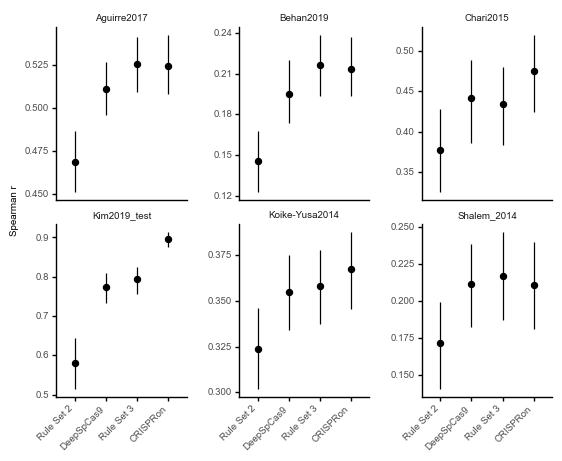

<ggplot: (8793098823783)>

In [9]:
g = point_range_plot(cor_performance_ci, 'model', 'spearman',
                     'spearman_025', 'spearman_975', xlabel='',
                     ylabel='Spearman r', wspace=0.4)
g.save('../figures/seq_rs3_performance.pdf', width=4, height=3)
g

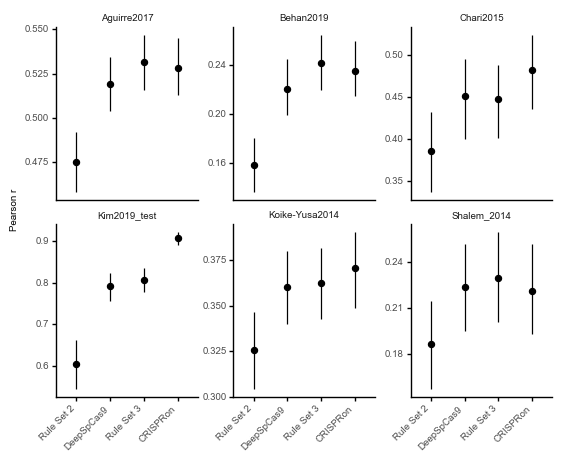

<ggplot: (8793097429498)>

In [10]:
point_range_plot(cor_performance_ci, 'model', 'pearson',
                 'pearson_025', 'pearson_975', xlabel='',
                 ylabel='Pearson r')

In [11]:
genomewide_predictions = long_predictions[long_predictions.genomewide].copy()
rank_loss_performance_ci = get_model_rank_loss(genomewide_predictions)

100%|██████████| 1000/1000 [02:23<00:00,  6.94it/s]


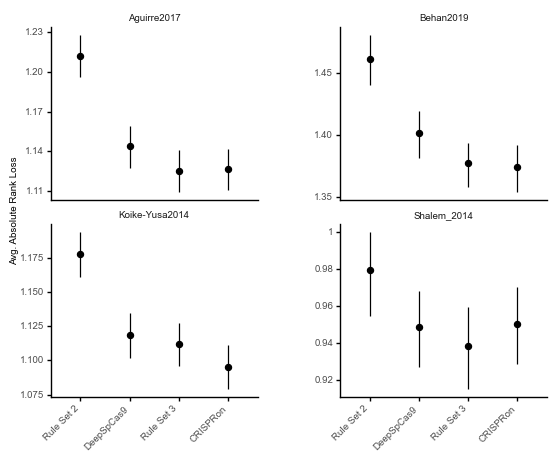

<ggplot: (8793092034286)>

In [13]:
g = point_range_plot(rank_loss_performance_ci, 'model', 'avg_abs_rank_diff',
                     'avg_abs_rank_diff_025', 'avg_abs_rank_diff_975', xlabel='',
                     ylabel='Avg. Absolute Rank Loss', wspace=0.4)
g
